# Sub Basin Delineation

Options: WhiteBoxTools, GrassGIS

In [52]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray 
import os
import shutil
import tempfile
import whitebox

In [3]:
# load toy data
dem = rioxarray.open_rasterio('../toy_data/dem_3m.tif')

## WhiteBoxTools

Workflow option 1:
 - Flow Accumulation (fill depressions, flow direction, flow accumulation)
 - Extract Streams (threshold flow accumulation)
 - SubBasins (input streams and flow direction)

In order to have reaches and not just stream network segments need option 2:
- Flow Accumulation
- Extract Streams
- Split Segments
- Get pour points (end of segment)
- Snap to flow accumulation (if using NHD)
- Watershed tool
- UnnestBasins (maybe not necessary)

In [18]:
def wb_wrapper(wbt_method, params, return_file=False):
    
    # for each param that is raster, save to file
    for p,v in params.items():
        if hasattr(v, 'rio'):
            # write v to temp file
            # update v to be the path to that file
            temp_file = tempfile.NamedTemporaryFile(suffix=".tif")
            v.rio.to_raster(temp_file.name, driver="GTiff")
            params[p] = temp_file.name
                

    # make function call
    wbt_method(**params)

    if return_file:
        return params['output']

    raster_file_path = params['output']
    output_raster = rioxarray.open_rasterio(raster_file_path)
    os.remove(raster_file_path)
    return output_raster 

def my_callback(value):
    if not "%" in value:
        print(value)

wbt = whitebox.WhiteboxTools()
wbt.set_whitebox_dir(os.path.expanduser("~/opt/WBT/"))

working_directory = os.path.abspath("../data/whitebox_outputs/")
if os.path.exists(working_directory):
    shutil.rmtree(working_directory)
os.mkdir(working_directory)
wbt.set_working_dir(os.path.abspath(working_directory))
wbt.version()

"WhiteboxTools v2.3.0 (c) Dr. John Lindsay 2017-2023\n\nWhiteboxTools is an advanced geospatial data analysis platform developed at\nthe University of Guelph's Geomorphometry and Hydrogeomatics Research \nGroup (GHRG). See www.whiteboxgeo.com for more details.\n"

### Option 1

In [20]:
# get flow direction and flow accumulation
params = {
    "dem": dem,
    "output": os.path.join(working_directory, "filled_dem.tif"),
    "dist": 1000,
    "max_cost": None,
    "min_dist": True,
    "flat_increment": None,
    "fill": True,
    "callback": my_callback
}

filled_dem_file = wb_wrapper(wbt.breach_depressions_least_cost, params, return_file=True)
filled_dem_file

./whitebox_tools --run="BreachDepressionsLeastCost" --wd="/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs" --dem='/var/folders/l2/9h6xd6f555321vx3s_ttqb_80000gn/T/tmp00h2pyfh.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/filled_dem.tif' --dist='1000' --min_dist --fill -v --compress_rasters=False

*****************************************
* Welcome to BreachDepressionsLeastCost *
* Powered by WhiteboxTools              *
* www.whiteboxgeo.com                   *
*****************************************
Reading data...
Num. solved pits: 876
Num. unsolved pits: 0
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.27s


'/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/filled_dem.tif'

In [21]:
params = {
    "dem": filled_dem_file, 
    "output": os.path.join(working_directory, "d8_pntr.tif"), 
    "esri_pntr": False, 
    "callback": my_callback
}
d8_pntr_file = wb_wrapper(wbt.d8_pointer, params, return_file=True)
d8_pntr_file

./whitebox_tools --run="D8Pointer" --wd="/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs" --dem='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/filled_dem.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/d8_pntr.tif' -v --compress_rasters=False

****************************
* Welcome to D8Pointer     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.44s


'/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/d8_pntr.tif'

In [24]:
params = {
    "i": d8_pntr_file,
    "output": os.path.join(working_directory, "d8_flow_acc.tif"),
    "out_type": "cells",
    "log": False,
    "clip": False,
    "pntr": True,
    "esri_pntr": False,
    "callback": my_callback
}
flow_acc = wb_wrapper(wbt.d8_flow_accumulation, params, return_file=False)

./whitebox_tools --run="D8FlowAccumulation" --wd="/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs" --input='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/d8_pntr.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/d8_flow_acc.tif' --out_type=cells --pntr -v --compress_rasters=False

*********************************
* Welcome to D8FlowAccumulation *
* Powered by WhiteboxTools      *
* www.whiteboxgeo.com           *
*********************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.77s


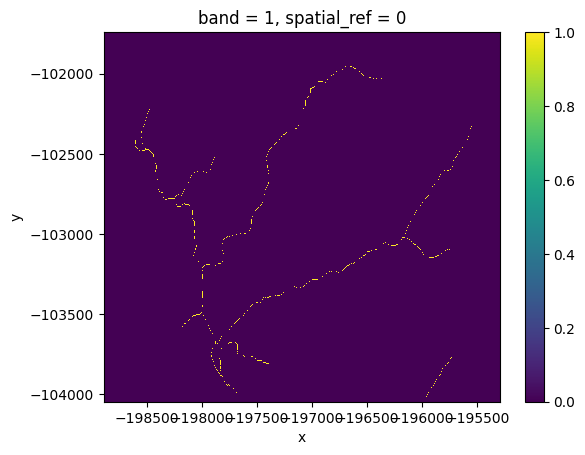

In [37]:
# decide on a threshold for flow accumulation
threshold = 20000
(flow_acc > threshold).plot()

In [40]:
params = {
    "flow_accum": flow_acc,
    "output": os.path.join(working_directory, "streams.tif"),
    "threshold": threshold,
    "zero_background": False,
    "callback": my_callback
}
streams_file = wb_wrapper(wbt.extract_streams, params, return_file=True)

./whitebox_tools --run="ExtractStreams" --wd="/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs" --flow_accum='/var/folders/l2/9h6xd6f555321vx3s_ttqb_80000gn/T/tmpc9qvyg3s.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/streams.tif' --threshold='20000' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.13s


In [66]:
params = {
    'd8_pntr': d8_pntr_file, 
    'streams': streams_file, 
    'output': os.path.join(working_directory, "subbasins.tif"), 
    'esri_pntr': False, 
    'callback': my_callback
}
basins = wb_wrapper(wbt.subbasins, params, return_file=False)

./whitebox_tools --run="Subbasins" --wd="/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs" --d8_pntr='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/d8_pntr.tif' --streams='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/streams.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/data/whitebox_outputs/subbasins.tif' -v --compress_rasters=False

****************************
* Welcome to Subbasins     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.94s


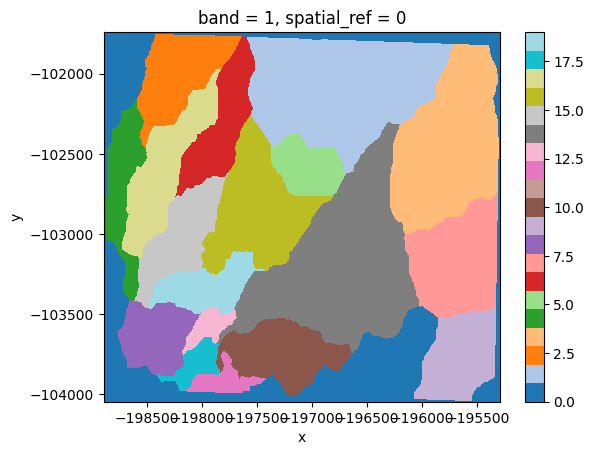

In [69]:
basins.data[basins.data == -32768] = 0
basins.plot(cmap='tab20')

## Option 2